In [ ]:
!nvidia-smi

Tue Dec  5 22:51:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    18W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


## * Axe 1 : Entraînement des modèles
  - CNN : Entraînement.
  - VGG16 : Fine-tuning.
  - EfficientNet : Fine-tuning.
  - MobileNet : Fine-tuning.

## * Axe 2 : Analyse comparative des modèles entraînés.

## * Axe 3 : Visualisation des Caractéristiques Apprises et Aide à la Prise de Décision en Agriculture
  - Application de Grad-CAM pour la Visualisation.


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# II) preparation des  dlonnées:

In [ ]:
import os
# Set the data folder path
data_folder_drive = 'drive/My Drive/plant_village_classification'

# List the contents of the data folder in Google Drive
os.listdir(data_folder_drive)

['Apple___Black_rot',
 'Apple___Apple_scab',
 'Apple___healthy',
 'Apple___Cedar_apple_rust']

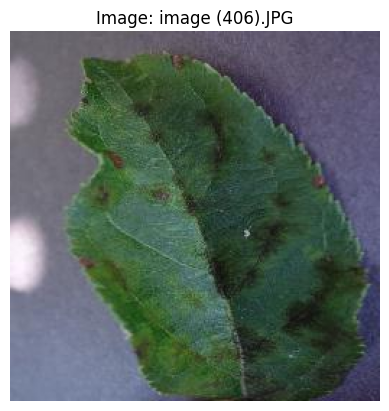

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Set the path to the data folder
data_folder_drive = 'drive/My Drive/plant_village_classification/Apple___Apple_scab'

# Get the list of image files in the folder
image_files = [f for f in os.listdir(data_folder_drive) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Choose the first image from the list
image_path = os.path.join(data_folder_drive, image_files[0])

# Load and display the image
img = Image.open(image_path)
plt.imshow(img)
plt.title(f'Image: {image_files[0]}')
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Set the path to the dataset
dataset_path = "drive/My Drive/plant_village_classification"

# Define image size and other parameters
img_size = (128, 128)
batch_size = 32

# Create a single data generator for all sets
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

print(' training generator:')
# Create training generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

print(' validation generator:')
# Create validation generator
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print(' testing generator:')
# Create test generator
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


 training generator:
Found 2537 images belonging to 4 classes.
 validation generator:
Found 634 images belonging to 4 classes.
 testing generator:
Found 3171 images belonging to 4 classes.


In [ ]:
#

# II) - Classification basé sur le modéle CNN:

> ##  1) -  Construction du modéle:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=train_generator.num_classes, activation='softmax'))


In [ ]:
model.summary()
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

> ## 2) - Compilation du modéle

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


> ### 3) - Entrainement du modéle:

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=validation_generator
)  # Adjust the number of epochs as needed


Epoch 1/7
80/80 [==============================] - 26s 297ms/step - loss: 1.0961 - accuracy: 0.6303 - val_loss: 0.3874 - val_accuracy: 0.8707
Epoch 2/7
80/80 [==============================] - 21s 267ms/step - loss: 0.4236 - accuracy: 0.8482 - val_loss: 0.4836 - val_accuracy: 0.8423
Epoch 3/7
80/80 [==============================] - 21s 263ms/step - loss: 0.4212 - accuracy: 0.8435 - val_loss: 0.2688 - val_accuracy: 0.9180
Epoch 4/7
80/80 [==============================] - 27s 345ms/step - loss: 0.2945 - accuracy: 0.8869 - val_loss: 0.2379 - val_accuracy: 0.9085
Epoch 5/7
80/80 [==============================] - 21s 261ms/step - loss: 0.2692 - accuracy: 0.9003 - val_loss: 0.2689 - val_accuracy: 0.9069
Epoch 6/7
80/80 [==============================] - 22s 276ms/step - loss: 0.2206 - accuracy: 0.9188 - val_loss: 0.1545 - val_accuracy: 0.9495
Epoch 7/7
80/80 [==============================] - 22s 273ms/step - loss: 0.1841 - accuracy: 0.9294 - val_loss: 0.1654 - val_accuracy: 0.9353


> ## 3 ) - Evaluation du modéle


>> ### a) accuracy:

In [ ]:
# Evaluate the model
accuracy = model.evaluate(test_generator)[1]
print(f"Test Accuracy: {accuracy}")

100/100 [==============================] - 20s 204ms/step - loss: 0.1691 - accuracy: 0.9385
Test Accuracy: 0.938505232334137


>> ### b) raport de classification et matrice de confusion:

100/100 [==============================] - 22s 216ms/step


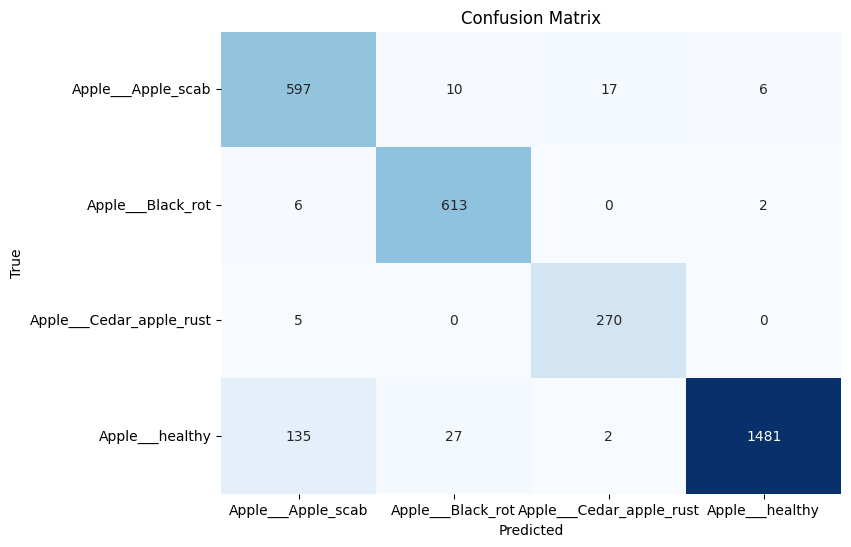

Classification Report:
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.80      0.95      0.87       630
       Apple___Black_rot       0.94      0.99      0.96       621
Apple___Cedar_apple_rust       0.93      0.98      0.96       275
         Apple___healthy       0.99      0.90      0.95      1645

                accuracy                           0.93      3171
               macro avg       0.92      0.95      0.93      3171
            weighted avg       0.94      0.93      0.94      3171



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator).argmax(axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)


>> ### c) ROC Curve

100/100 [==============================] - 23s 232ms/step


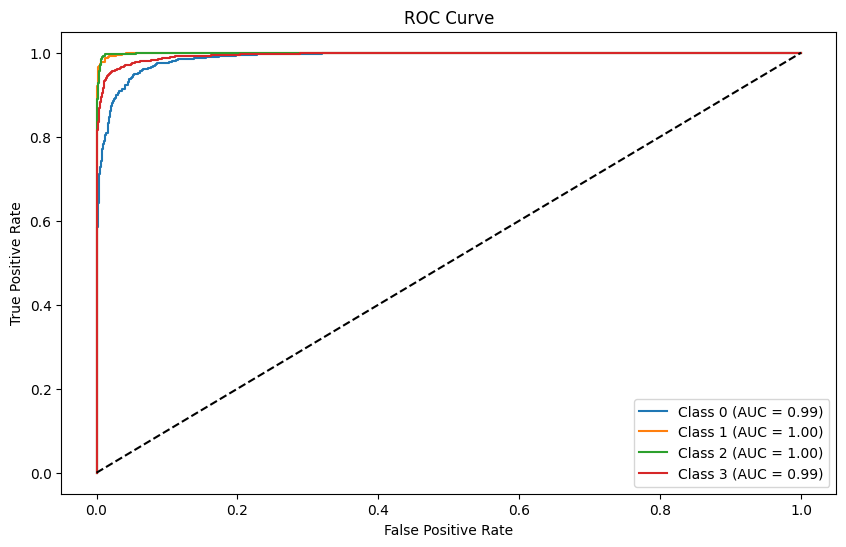

In [ ]:


# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to categorical for ROC curve
from sklearn.preprocessing import label_binarize
true_labels_bin = label_binarize(true_labels, classes=list(test_generator.class_indices.values()))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes=4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], model.predict(test_generator)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# III) Classification basè sur le modèle VGG19 (Fine-Tuning)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

> ## 1) - Importation et préparation du modéle:

In [ ]:
# Use VGG19 as the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))
# test_generator , train_generator , validation_generator

> ## 2) - Compilation et Entrainement du modéle

In [ ]:
# Compile the model
model.compile(optimizer=optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
80/80 [==============================] - 30s 364ms/step - loss: 0.6615 - accuracy: 0.7734 - val_loss: 0.2590 - val_accuracy: 0.9259
Epoch 2/10
80/80 [==============================] - 25s 315ms/step - loss: 0.3326 - accuracy: 0.8932 - val_loss: 0.1793 - val_accuracy: 0.9448
Epoch 3/10
80/80 [==============================] - 24s 303ms/step - loss: 0.2886 - accuracy: 0.8983 - val_loss: 0.1662 - val_accuracy: 0.9385
Epoch 4/10
80/80 [==============================] - 31s 394ms/step - loss: 0.2737 - accuracy: 0.9038 - val_loss: 0.1600 - val_accuracy: 0.9432
Epoch 5/10
80/80 [==============================] - 28s 350ms/step - loss: 0.2271 - accuracy: 0.9283 - val_loss: 0.1212 - val_accuracy: 0.9590
Epoch 6/10
80/80 [==============================] - 28s 348ms/step - loss: 0.2222 - accuracy: 0.9212 - val_loss: 0.1552 - val_accuracy: 0.9495
Epoch 7/10
80/80 [==============================] - 30s 371ms/step - loss: 0.2123 - accuracy: 0.9227 - val_loss: 0.1458 - val_accuracy: 0.9369

> ## Evaluation du modéle

>> ### a) accuracy :

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss}")

100/100 [==============================] - 23s 230ms/step - loss: 0.1406 - accuracy: 0.9495
Test Accuracy: 94.95%
Test Loss: 0.1405746191740036


>> ### b) Mtrice de confusion et Rapport de classification.

100/100 [==============================] - 24s 238ms/step


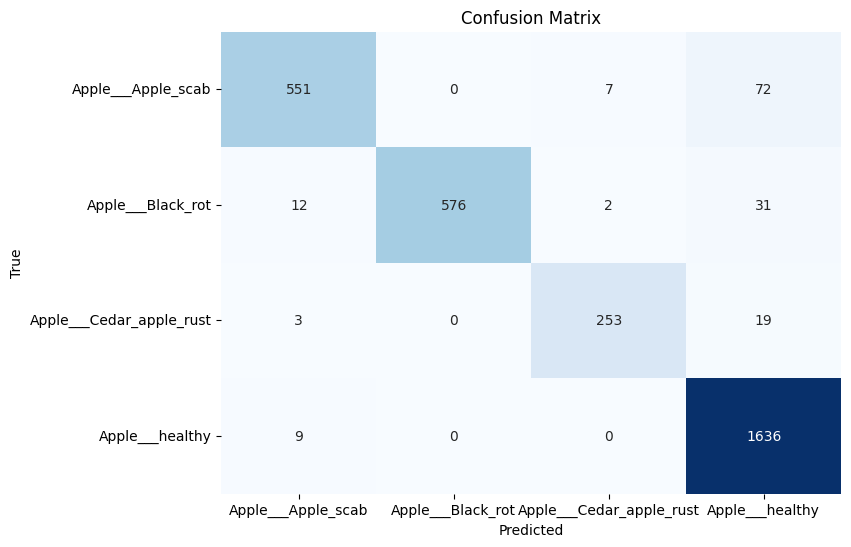

Classification Report:
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.96      0.87      0.91       630
       Apple___Black_rot       1.00      0.93      0.96       621
Apple___Cedar_apple_rust       0.97      0.92      0.94       275
         Apple___healthy       0.93      0.99      0.96      1645

                accuracy                           0.95      3171
               macro avg       0.96      0.93      0.95      3171
            weighted avg       0.95      0.95      0.95      3171



In [ ]:
# Predictions on the test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

>> ### c) ROC Curve

100/100 [==============================] - 23s 230ms/step


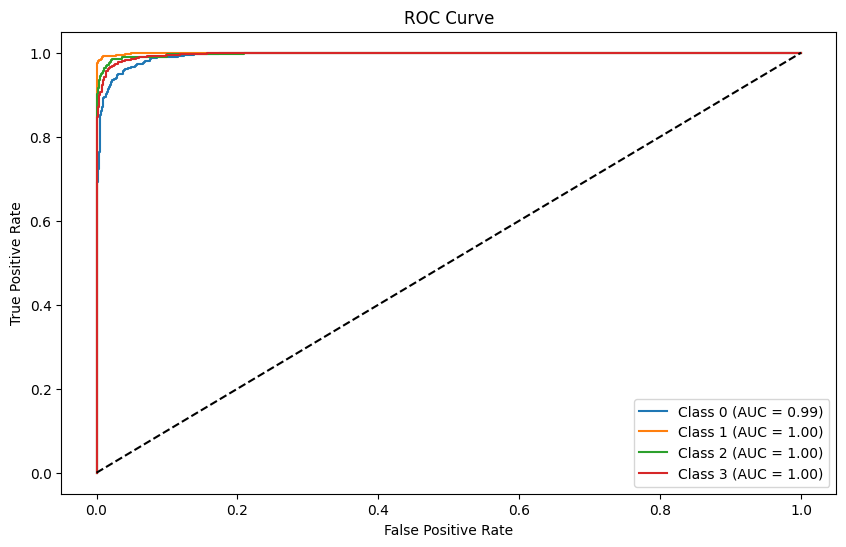

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to categorical for ROC curve
from sklearn.preprocessing import label_binarize
true_labels_bin = label_binarize(true_labels, classes=list(test_generator.class_indices.values()))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes=4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], model.predict(test_generator)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

 # IV) Classification basé sur ResNet50 (Fine-TUning)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


> ## 1) - Importation et préparation du modéle

In [ ]:
# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
# Create a new model for fine-tuning
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])


94765736/94765736 [==============================] - 1s 0us/step


> ## 2) - Compilation et Entrainemet du modèle

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
80/80 [==============================] - 31s 315ms/step - loss: 1.1830 - accuracy: 0.5136 - val_loss: 1.1540 - val_accuracy: 0.5410
Epoch 2/10
80/80 [==============================] - 24s 298ms/step - loss: 1.1434 - accuracy: 0.5215 - val_loss: 1.1023 - val_accuracy: 0.5268
Epoch 3/10
80/80 [==============================] - 29s 358ms/step - loss: 1.0921 - accuracy: 0.5376 - val_loss: 1.0605 - val_accuracy: 0.5521
Epoch 4/10
80/80 [==============================] - 29s 359ms/step - loss: 1.0650 - accuracy: 0.5499 - val_loss: 1.0303 - val_accuracy: 0.5442
Epoch 5/10
80/80 [==============================] - 30s 375ms/step - loss: 1.0208 - accuracy: 0.5684 - val_loss: 1.0129 - val_accuracy: 0.5521
Epoch 6/10
80/80 [==============================] - 23s 281ms/step - loss: 1.0124 - accuracy: 0.5755 - val_loss: 0.9725 - val_accuracy: 0.5962
Epoch 7/10
80/80 [==============================] - 22s 274ms/step - loss: 0.9888 - accuracy: 0.5861 - val_loss: 0.9917 - val_accuracy: 0.5584

> ## 3) Evaluation du modèle

>> ### a) accuracy

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss}")


100/100 [==============================] - 26s 264ms/step - loss: 0.9785 - accuracy: 0.6001
Test Accuracy: 60.01%
Test Loss: 0.9785311222076416


>> ### b) - Matrice de confusion et Rapport de classification

100/100 [==============================] - 28s 269ms/step


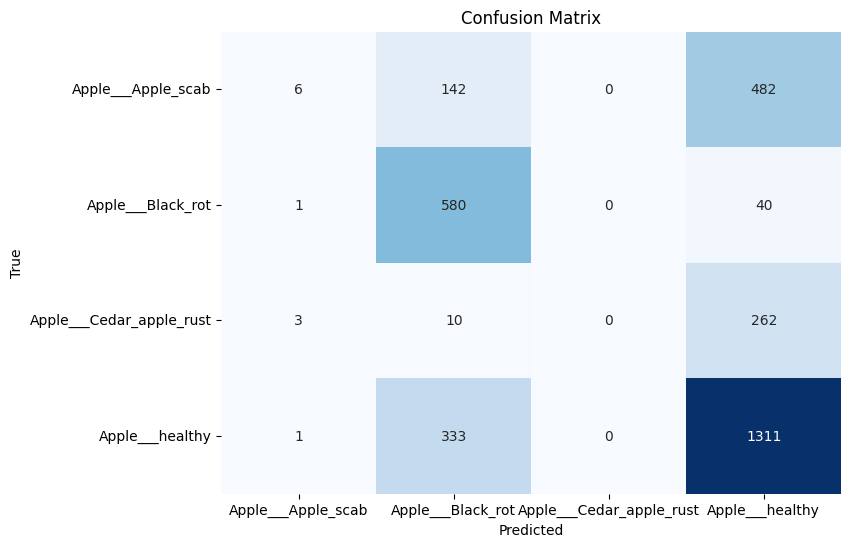

Classification Report:
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.55      0.01      0.02       630
       Apple___Black_rot       0.54      0.93      0.69       621
Apple___Cedar_apple_rust       0.00      0.00      0.00       275
         Apple___healthy       0.63      0.80      0.70      1645

                accuracy                           0.60      3171
               macro avg       0.43      0.44      0.35      3171
            weighted avg       0.54      0.60      0.50      3171



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Get true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator).argmax(axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

>> ### c) - ROC Curve

100/100 [==============================] - 28s 279ms/step


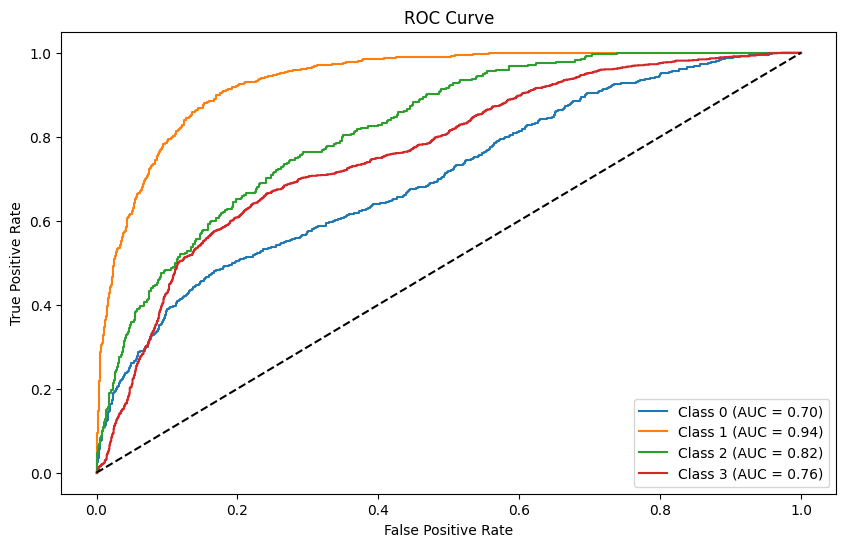

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to categorical for ROC curve
from sklearn.preprocessing import label_binarize
true_labels_bin = label_binarize(true_labels, classes=list(test_generator.class_indices.values()))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes=4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], model.predict(test_generator)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# V) Classification basé sur MobileNet

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

> ## 1) Importation it préparation du modèle

In [ ]:
# Load the pre-trained MobileNet model with fine-tuning
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add a custom top model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))


17225924/17225924 [==============================] - 0s 0us/step


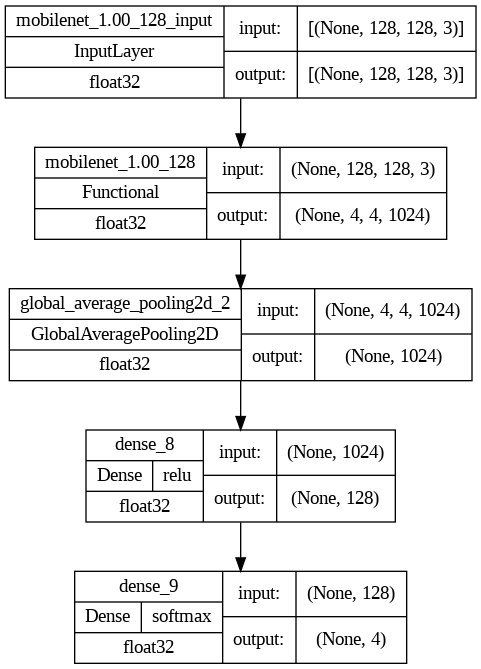

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_dtype=True, show_layer_activations=True)

> ## 2) Compilation et entrainement du modéle

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)  # Adjust the number of epochs as needed


Epoch 1/10
80/80 [==============================] - 40s 327ms/step - loss: 0.2738 - accuracy: 0.9192 - val_loss: 1.8350 - val_accuracy: 0.7934
Epoch 2/10
80/80 [==============================] - 23s 291ms/step - loss: 0.0884 - accuracy: 0.9732 - val_loss: 0.2936 - val_accuracy: 0.9369
Epoch 3/10
80/80 [==============================] - 21s 266ms/step - loss: 0.0593 - accuracy: 0.9815 - val_loss: 0.0744 - val_accuracy: 0.9811
Epoch 4/10
80/80 [==============================] - 31s 383ms/step - loss: 0.0423 - accuracy: 0.9858 - val_loss: 0.0172 - val_accuracy: 0.9921
Epoch 5/10
80/80 [==============================] - 22s 273ms/step - loss: 0.0285 - accuracy: 0.9858 - val_loss: 0.1226 - val_accuracy: 0.9621
Epoch 6/10
80/80 [==============================] - 23s 287ms/step - loss: 0.0324 - accuracy: 0.9901 - val_loss: 0.0551 - val_accuracy: 0.9890
Epoch 7/10
80/80 [==============================] - 24s 297ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 0.0188 - val_accuracy: 0.9937

> ## 3) Evaluation du modèle

>> ### a) accuracy

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss}")

100/100 [==============================] - 31s 315ms/step - loss: 0.0667 - accuracy: 0.9801
Test Accuracy: 98.01%
Test Loss: 0.06674008816480637


>> ### b) Matrice de confudion et rapport de classification du model

100/100 [==============================] - 27s 263ms/step


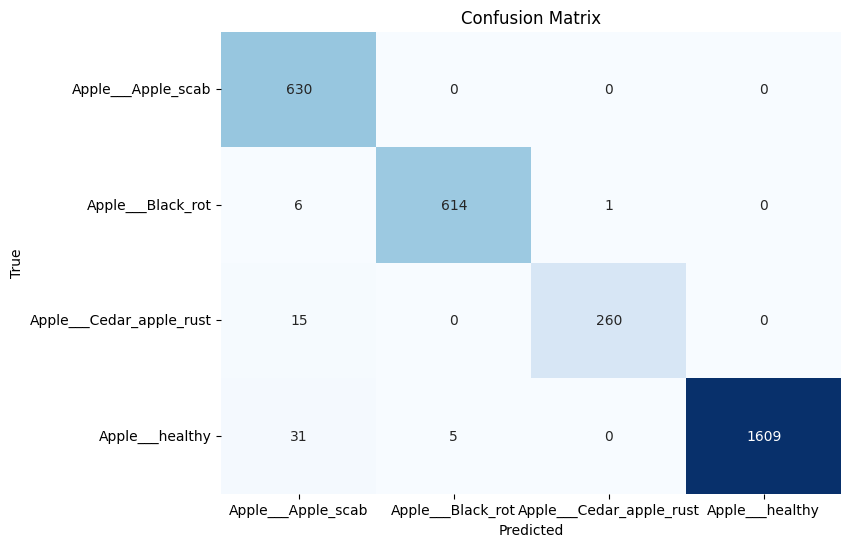

Classification Report:
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.92      1.00      0.96       630
       Apple___Black_rot       0.99      0.99      0.99       621
Apple___Cedar_apple_rust       1.00      0.95      0.97       275
         Apple___healthy       1.00      0.98      0.99      1645

                accuracy                           0.98      3171
               macro avg       0.98      0.98      0.98      3171
            weighted avg       0.98      0.98      0.98      3171



In [ ]:
# Predictions on the test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

>> ###  c) ROC Curve

100/100 [==============================] - 26s 256ms/step


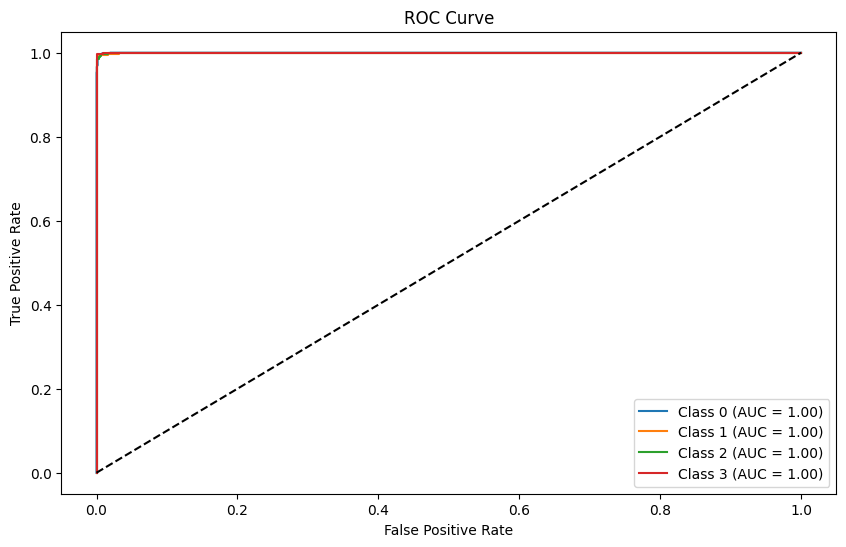

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to categorical for ROC curve
from sklearn.preprocessing import label_binarize
true_labels_bin = label_binarize(true_labels, classes=list(test_generator.class_indices.values()))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes=4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], model.predict(test_generator)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# VI) analyse comparative pour discuter des forces et faiblesses des différents mod`eles

In [ ]:
p
data_col =['accuracy','precision_avg', 'recall_avg' ,'f1-score_avg']
metrics_CNN = [0.938,0.92 ,0.95 , 0.93]
metrics_VGG19 = [0.9495,0.96 ,0.93 , 0.95]
metrics_EfficientNet = [0.6001,0.43 ,0.44 , 0.35]
metrics_MobileNet = [0.9801,0.98 ,0.98 , 0.98]


In [ ]:
import pandas as pd

data_col = ['accuracy', 'precision_avg', 'recall_avg', 'f1-score_avg']

metrics_CNN = [0.938, 0.92, 0.95, 0.93]
metrics_VGG19 = [0.9495, 0.96, 0.93, 0.95]
metrics_EfficientNet = [0.6001, 0.43, 0.44, 0.35]
metrics_MobileNet = [0.9801, 0.98, 0.98, 0.98]

data = {
    'Model': ['CNN', 'VGG19', 'EfficientNet', 'MobileNet'],
    'accuracy': metrics_CNN,
    'precision_avg': metrics_VGG19,
    'recall_avg': metrics_EfficientNet,
    'f1-score_avg': metrics_MobileNet
}

df = pd.DataFrame(data, columns=['Model'] + data_col)
df

,Model,accuracy,precision_avg,recall_avg,f1-score_avg
0,CNN,0.938,0.9495,0.6001,0.9801
1,VGG19,0.920,0.9600,0.4300,0.9800
2,EfficientNet,0.950,0.9300,0.4400,0.9800
3,MobileNet,0.930,0.9500,0.3500,0.9800


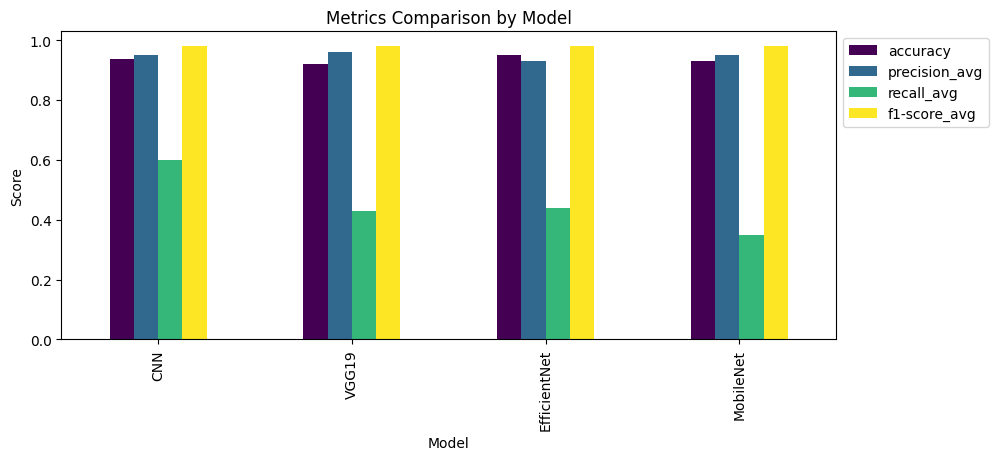

In [ ]:
# Plot the bar graph
df.set_index('Model')[data_col].plot(kind='bar', figsize=(10, 4), colormap='viridis')
plt.title('Metrics Comparison by Model')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## *`--> Modèle CNN -------------------------------`* :

> ## ***1) - Points forts ***:

- Performe bien pour la gale des pommes et la pourriture noire, avec une précision, un rappel et un score F1 élevés.
Atteint une précision globale élevée (93 %).
- Les pommes saines sont classées avec une précision et un rappel élevés.
> ## ***`Points faibles`*** :

- Rappel inférieur pour la rouille du cèdre (0,98), suggérant des difficultés potentielles pour identifier cette maladie.

## *`--> Modèle VGG19  -------------------------------`* :

> ## ***1) - Points forts ***:

- Précision et rappel élevés pour la pourriture noire et les pommes saines.
- Précision globale élevée (95 %).
> ## ***`Points faibles`*** :

- Rappel plus faible pour la gale des pommes (0,87), indiquant des difficultés potentielles à identifier correctement cette maladie.
- Précision légèrement plus faible pour la rouille du cèdre.

## *`--> Modèle EfficientNet  -------------------------------`* :

> ## ***1) - Points forts ***:

- Obtient un rappel plus élevé pour la pourriture noire (0,93) par rapport au CNN.
- Précision modérée (60 %).
> ## ***`Points faibles`*** :

- Mauvaises performances pour la gale des pommes et la rouille du cèdre, avec un rappel très faible.
- Généralement, une précision et un score F1 inférieurs.

## *`--> Modèle MobileNet   -------------------------------`* :
> ## ***1) - Points forts ***:

- Précision, rappel et score F1 élevés pour toutes les classes.
- Excellente précision globale (98 %).
> ## ***`Points faibles`*** :

- Aucun évident selon les résultats fournis.

## *`--> Observations générales :  -------------------------------`* :

- **MobileNet** surpasse les autres modèles, atteignant la plus haute précision et une performance robuste pour toutes les classes.
- **EfficientNet** montre des faiblesses dans l'identification de la gale des pommes et de la rouille du cèdre.
- **VGG19** se comporte bien, mais rencontre des défis avec la gale des pommes.
- **CNN** se comporte raisonnablement bien, surtout pour la pourriture noire et les pommes saines.

## *`--> Implications pratiques  -------------------------------`* :

- **MobileNet** pourrait être un choix préféré en raison de sa haute précision, en le rendant fiable pour la détection des maladies dans des applications pratiques.
- **VGG19** et **CNN** pourraient être des alternatives adaptées, mais leur précision inférieure et leurs faiblesses spécifiques doivent être prises en compte.
- **EfficientNet** pourrait ne pas être le meilleur choix en raison de ses performances globales plus faibles.

# VII) Visualisation des Caract´eristiques Apprises et Aide `a la Prise de D´ecision en Agriculture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build a CNN model with additional convolutional layers
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))  # Additional convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))  # Additional convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))  # Additional convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=train_generator.num_classes, activation='softmax'))


In [ ]:
model.summary()
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=validation_generator
)  # Adjust the number of epochs as needed


Epoch 1/7
80/80 [==============================] - 30s 326ms/step - loss: 0.9169 - accuracy: 0.6263 - val_loss: 0.6252 - val_accuracy: 0.7571
Epoch 2/7
80/80 [==============================] - 20s 254ms/step - loss: 0.6012 - accuracy: 0.7757 - val_loss: 0.5456 - val_accuracy: 0.8139
Epoch 3/7
80/80 [==============================] - 22s 277ms/step - loss: 0.5274 - accuracy: 0.8092 - val_loss: 0.4717 - val_accuracy: 0.8344
Epoch 4/7
80/80 [==============================] - 23s 285ms/step - loss: 0.4197 - accuracy: 0.8384 - val_loss: 0.3564 - val_accuracy: 0.8849
Epoch 5/7
80/80 [==============================] - 27s 344ms/step - loss: 0.3408 - accuracy: 0.8719 - val_loss: 0.2908 - val_accuracy: 0.9069
Epoch 6/7
80/80 [==============================] - 20s 251ms/step - loss: 0.2866 - accuracy: 0.8963 - val_loss: 0.2341 - val_accuracy: 0.9259
Epoch 7/7
80/80 [==============================] - 21s 265ms/step - loss: 0.2657 - accuracy: 0.8991 - val_loss: 0.3193 - val_accuracy: 0.8912


> ## Application de Grad-CAM pour la Visualisation: pretrained VGG16 DL model

200/200 [==============================] - 13s 67ms/step - Score: 971.0451 - TotalVariation2D: 12.9895 - Norm: 38.9255


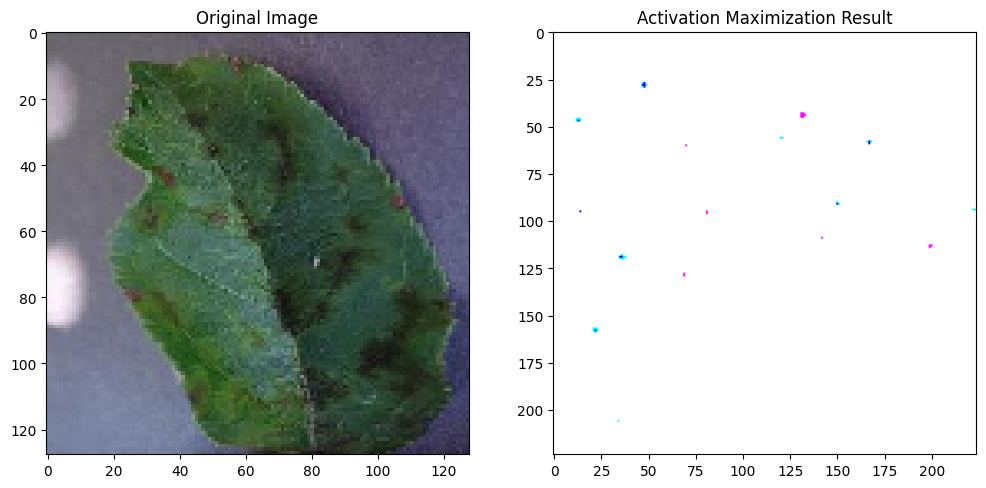

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from matplotlib import pyplot as plt
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
FILTER_INDEX = 0  # Replace with your desired filter index

vgg16_model = VGG16(weights='imagenet')
activation_maximization = \
   ActivationMaximization(vgg16_model,
                          model_modifier=[ExtractIntermediateLayer('block5_conv3'),
                                          ReplaceToLinear()],
                          clone=False)
activations = \
   activation_maximization(CategoricalScore(FILTER_INDEX),
                           steps=200,
                           input_modifiers=[Jitter(jitter=16), Rotate2D(degree=1)],
                           regularizers=[TotalVariation2D(weight=1.0),
                                         Norm(weight=0.3, p=1)],
                           optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
                           callbacks=[Progress()])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(seed_img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(activations[0])
plt.title('Activation Maximization Result')

plt.show()


> ## Application de Grad-CAM pour la Visualisation: CNN DL model

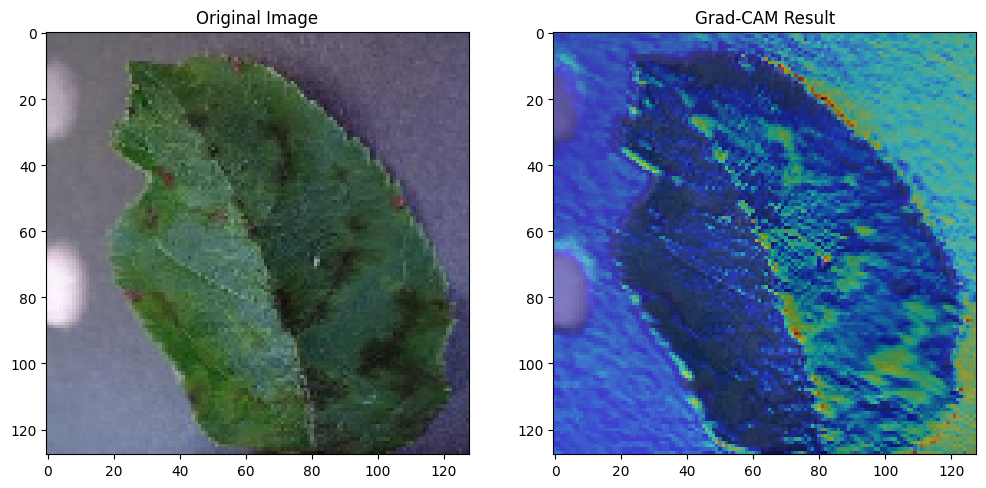

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

YOUR_MODEL_INSTANCE = model  # Replace with your actual model instance
CATEGORICAL_INDEX = 0  # Replace with your desired categorical index
SEED_INPUT_PATH = "drive/My Drive/plant_village_classification/Apple___Apple_scab/image (406).JPG"  # Replace with your seed input image path
seed_img = image.load_img(SEED_INPUT_PATH, target_size=(128, 128))
seed_input = image.img_to_array(seed_img)
seed_input = np.expand_dims(seed_input, axis=0)
seed_input = preprocess_input(seed_input)
activation_layer_name = 'conv2d_2'
visualization_model = Model(inputs=YOUR_MODEL_INSTANCE.input,
                            outputs=YOUR_MODEL_INSTANCE.get_layer(activation_layer_name).output)
gradcam = GradcamPlusPlus(visualization_model,
                          model_modifier=ReplaceToLinear(),
                          clone=True)
cam = gradcam(CategoricalScore(CATEGORICAL_INDEX), seed_input)
# Plot the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(seed_img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
# Overlay Grad-CAM on the original image
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(seed_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('Grad-CAM Result')

plt.show()

# fin